# CHALLENGE PROBLEM - RECOMMENDER SYSTEM

Author- Pranav Sivadas Menon

In this challenge problem I will be building a recommender system by using collaborative filtering to make recommendations on the MovieLens Dataset.

A recommender system is a technology that is deployed in the environment where items (products, movies, events, articles) are to be recommended to users (customers, visitors, app users, readers) or the opposite.

There are three types of collaborative filtering algorithms

User-user approaches: Estimate user's rating of an item by finding “similar” users and then looking at their predictions for this item.

Item-item approaches: Estimate a user’s rating of a item by finding similar items and then looking at the user’s rating of these similar items.

Matrix factorization: Construct a low-rank matrix that approximates the observed entries of the rating matrix.

## Collaborative Filtering by Matrix Factorization

In collaborative filtering we factorize our ratings matrix into a two feature matrices whose product is equal to the original ratings matrix. Initially, we have some partially filled ratings matrix $X\in \mathbb{R}^{m\times n}$, our objective is to find the feature matrices  $U \in \mathbb{R}^{m\times k}$ and $V \in \mathbb{R}^{n\times k}$ such that $UV^T = X$. Each row of $V$ is features corresponding to a movie, hence $u_i^Tv_j$ is the predicted rating of user $i$ on movie $j$. The aforementioned statement represents the hypothesis function for collaborative filtering:


$X$ is only partially filled and sparse, 0 is used to indicate the non-presence of a particular rating.Let $S$ be the set of $(i,j)$ such that $X_{i,j} \neq 0$, so $S$ represents the set of all pairs for which we have a rating. 

The loss function used for collaborative filtering is the squared loss:

$$\ell(h_\theta(i,j),X_{i,j}) = (h_\theta(i,j) - X_{i,j})^2$$

Also impose an $l_2$ regularization on the parameters, total loss function is:

$$\sum_{i,j\in S}\ell(h_\theta(i,j),X_{i,j}) + \lambda_u ||U||_2^2 + \lambda_v ||V||_2^2$$

For this problem I'm assuming 



## MovieLens rating dataset

Let's get the MovieLens dataset. I will be using their smaller subset of 100k ratings. 

Download the archive containing their dataset release from 
https://grouplens.org/datasets/movielens/

For more details (contents and structure of archive), you can read the README at 
http://files.grouplens.org/datasets/movielens/ml-latest-README.html

General information can be obtained from their website description located at 
http://grouplens.org/datasets/movielens/.

For this challenge problem I will be looking at the ratings data specifically.

However, additional data is available (i.e. movie data and user made tags for movies) which could be used to improve the ability of the recommender system.

## Exploratary Analysis and Data Preparation

In [1]:
import numpy as np
import pandas as pd
import math
import scipy.sparse as sp
import scipy.linalg as la
from collections import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [22]:
# read the csv file  
movies = pd.read_csv('/home/pranav/Desktop/ml-latest-small/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
# counting the top movies genres
movies.genres.value_counts()[:15]

Drama                   1170
Comedy                   809
Comedy|Drama             425
Documentary              365
Drama|Romance            356
Comedy|Romance           341
Comedy|Drama|Romance     264
Horror                   183
Drama|Thriller           172
Crime|Drama              135
Crime|Drama|Thriller     116
Horror|Thriller          112
Drama|War                107
Comedy|Crime              77
Thriller                  74
Name: genres, dtype: int64

In [21]:
ratings = pd.read_csv("/home/pranav/Desktop/ml-latest-small/ratings.csv")
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [5]:
# looking at general characteristics of the userId and rating
ratings[['userId','rating']].describe()

,userId,rating
count,100004.000000,100004.000000
mean,347.011310,3.543608
std,195.163838,1.058064
min,1.000000,0.500000
25%,182.000000,3.000000
50%,367.000000,4.000000
75%,520.000000,4.000000
max,671.000000,5.000000


In [6]:
X = np.asarray(sp.coo_matrix((ratings["rating"], (ratings["userId"]-1, ratings["movieId"]-1))).todense())

# keeping movies with only 5 or more ratings
X_valid = (X!=0).sum(axis=0) >= 5
X = X[:,X_valid]

rows,cols = X.shape[0],X.shape[1]

# User mean ratings and movie mean ratings
means_user = np.array([X[m,X[m,:]!=0].mean() for m in range(rows)])
means_movie = np.array([X[X[:,n]!=0,n].mean() for n in range(cols)])

Text(0,0.5,'Count')

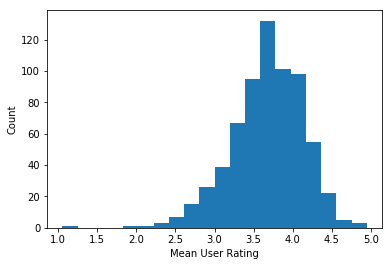

In [7]:
plt.hist(means_user, bins=20)
plt.xlabel("Mean User Rating")
plt.ylabel("Count")

Text(0,0.5,'Count')

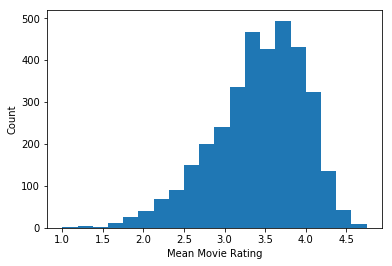

In [8]:
plt.hist(means_movie, bins=20)
plt.xlabel("Mean Movie Rating")
plt.ylabel("Count")

Text(0,0.5,'Number of Users')

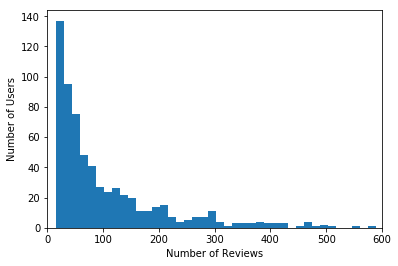

In [9]:
num_of_user_rev = (X!=0).astype(float).sum(axis=1)
plt.hist(num_of_user_rev,bins=100)
plt.xlim([0,600])
plt.xlabel("Number of Reviews")
plt.ylabel("Number of Users")

In [10]:
def preparation(ratings, movies, Permutation_array):
    """ 
        Parameters: 
            ratings (dataframe) : dataframe of MovieLens ratings
            movies (dataframe) : dataframe of MovieLens movies
            Permutation_array (numpy 1D array) : random permutation vector
            
        Returns: 
            (Train_mat, Test_mat,Valid_mat, movie_names)  : training, validation and testing splits of the ratings 
                                            matrix (all 3 numpy 2D arrays), and a list of movie names )
                                         
                                         
    """
    u_l=len(ratings['userId'].unique())
    m_l=len(ratings['movieId'].unique())
   
    indices=int(np.floor(7*len(Permutation_array))/10)
    remain = int(np.floor((len(Permutation_array) - indices)/3))
    
    ## Randomly splitting into training validation and testing
    
    Train_val=ratings.iloc[Permutation_array[0:indices],:]
    Valid_val=ratings.iloc[Permutation_array[indices:indices + remain],:]
    Test_val=ratings.iloc[Permutation_array[indices + remain:],:]
    
    ## Creating empty training,validation and testing matrices
    
    Train_mat=np.zeros((u_l,m_l))
    Test_mat=np.zeros((u_l,m_l))
    Valid_mat=np.zeros((u_l,m_l))

    val_mat=range(1,m_l+1)
   
    ## creating a mapping dictionary of movieId with moviename
    
    un_mov=sorted(ratings['movieId'].unique())
    map_dict= dict(zip(un_mov,[x for x in val_mat]))
    map_dict=OrderedDict(map_dict)
    
    ## Storing values into train,validation and test matrices
    
    for value in Train_val.itertuples():
        Train_mat[value[1]-1,map_dict[value[2]]-1]=value[3]
     
    for value in Test_val.itertuples():
        Test_mat[value[1]-1,map_dict[value[2]]-1]=value[3]
        
    for value in Valid_val.itertuples():
        Valid_mat[value[1]-1,map_dict[value[2]]-1]=value[3]
   
    movies=movies.set_index(movies['movieId'])
    movie_name=[movies['title'][movie] for movie in un_mov]
    
    return (Train_mat,Test_mat,Valid_mat,movie_name)

## Test the above function

In [11]:
Train_mat, Test_mat,Valid_mat, movie_names = preparation(ratings, movies, np.random.permutation(len(ratings)))
print('Training matrix shape: {}'.format(Train_mat.shape))
print('Validation matrix shape: {}'.format(Valid_mat.shape))
print('Testing matrix shape: {}'.format(Test_mat.shape))
print()
print('movie names: {}'.format(movie_names[:10]))

Training matrix shape: (671, 9066)
Validation matrix shape: (671, 9066)
Testing matrix shape: (671, 9066)

movie names: ['Toy Story (1995)', 'Jumanji (1995)', 'Grumpier Old Men (1995)', 'Waiting to Exhale (1995)', 'Father of the Bride Part II (1995)', 'Heat (1995)', 'Sabrina (1995)', 'Tom and Huck (1995)', 'Sudden Death (1995)', 'GoldenEye (1995)']


## Alternating Least Squares for Collaborative Filtering

Now we build the collaborative filtering recommender system. We will use a method known as alternating least squares. We will alternate between optimizing over $U$ and $V$ by holding the other constant. I used the alternating least squares approach since by using this approach, we get exactly a weighted least squares problem, which has a well-known solution. Please look at this link to see the ALS formulae and learn more  http://stanford.edu/~rezab/classes/cme323/S15/notes/lec14.pdf

W-  indicator matrix where $W_{ij} = 1$ if there is a rating in $X_{ij}$


In [12]:
def error(X, U, V):
    """ mean error of the observed ratings in X and their estimated values. 
    
        Parameters: 
            X (numpy 2D array) : a ratings matrix
            U (numpy 2D array) : a matrix of features for each user
            V (numpy 2D array) : a matrix of features for each movie
            
        Returns: 
            (float) : the mean squared error of the observed ratings with their estimated values
        """
    W=(X>0).astype(float)
    
    pred=np.dot(U,V.T)
    J=np.multiply(((X-pred)**2),W)
    error=J.sum()/W.sum()
    
    return error

In [13]:
def training(Train_mat, Valid_mat, k, U, V, num_iters, lam):
    """  
        Parameters: 
            Train_mat (numpy 2D array) : the training ratings matrix
            Test_mat (numpy 2D array) : the testing ratings matrix
            k (int) : the number of features use in the  model
            U (numpy 2D array) : initial matrix of features for each user
            V (numpy 2D array) : initial matrix of features for each movie
            num_iters (int) : number of iterations to run
            lam (int) : regularization parameter

        Returns:
            (U,V,error_values) : A pair of the resulting learned matrix factorization and error values
    """
   
    reg = lam* sp.eye(k)
    
    W = (Train_mat > 0).astype(int)
    
    for epoch in range(num_iters):
        for u,Wu in enumerate(W.T):
            
            term1 = U.T.dot(sp.diags(Wu).dot(U)) + reg
            term2 = U.T.dot(Train_mat[:,u])
            V[u,:] = la.solve(term1,term2) 
            
        for v,Wv in enumerate(W):
            
            term1 = V.T.dot(sp.diags(Wv).dot(V)) + reg
            term2 = V.T.dot(Train_mat[v,:])
            U[v,:] = la.solve(term1,term2) 
            
        
    error_on_valid = round(error(Valid_mat, U, V),4)
            
    return (U,V,error_on_valid)
            

# Grid Search to find best hyperparameters

Grid search is a technique to perform hyperparameter optimization, which is simply an exhaustive search through a manually pre-defined subset of the hyperparameter space of a learning algorithm. A grid search algorithm must be guided by some performance metric, in this case evaluation on a held-out validation set.

In [14]:
def gridsearch(k_values,lam_values,epochs):
    """  
        Parameters: 
            k_values(list) : list of k values to try
            lam_values(list) : list of lam_values to try
            epochs (int) : number of iterations to run

        Returns:
            (error_val,lam_best,k_best) : error value on test validation set, best lam and k values
    """
    max_val=np.inf
    k_best = 0
    lam_best = 0

    for k in k_values:
    
        U = np.random.rand(Train_mat.shape[0],k)
        V = np.random.rand(Train_mat.shape[1],k)
    
        for lam in lam_values:
            
            U,V,error_val = training(Train_mat, Valid_mat, k, U, V, num_iters=epochs, lam=lam)
            
            print('Error value on validation set: {}, lamba value: {}, k value: {}'.format(error_val,lam,k))
            
            if error_val < max_val:
                max_val = error_val
                lam_best = lam
                k_best = k

    return (max_val,lam_best,k_best,U,V)
    
        

## Building the recommender system with best parameters

In [15]:
epochs = 25
k_mat = [5,10,15]
lam_mat = [0.1,1,10]
error_val,lam_best,k_best,U,V = gridsearch(k_mat,lam_mat,epochs)
print()
print('The best lamba: {}'.format(lam_best))
print('The best k: {}'.format(k_best))
print('The error on validation set with above parameters is: {}'.format(error_val))

Error value on validation set: 2.0341, lamba value: 0.1, k value: 5
Error value on validation set: 1.9332, lamba value: 1, k value: 5
Error value on validation set: 1.6663, lamba value: 10, k value: 5
Error value on validation set: 2.3265, lamba value: 0.1, k value: 10
Error value on validation set: 2.1251, lamba value: 1, k value: 10
Error value on validation set: 1.6982, lamba value: 10, k value: 10
Error value on validation set: 2.5593, lamba value: 0.1, k value: 15
Error value on validation set: 2.291, lamba value: 1, k value: 15
Error value on validation set: 1.7133, lamba value: 10, k value: 15

The best lamba: 10
The best k: 5
The error on validation set with above parameters is: 1.6663


The Mean Square Error will continuously decrease on the training set as k increases as the original matrix is being approximated by a matrix of a higher rank. On the validation set, however, the error will  start increasing because the training set is overfitting to the  user tastes. 

## Making Recommendations and Computing error on Test set

Finally, we need to make recommendations given a matrix factorization. We can do this by recommending the movie with the highest value in the estimated ratings matrix.

For each user the movie with the highest predicted rating for that user, that the user hasn't seen before is recommended.

The result is returned in a list such that the i th element in this list is the recommendation for the user corresponding to the i th row of the ratings matrix.



In [16]:
def recommendations(X, U, V, Movie_names):
    """ 
        Parameters: 
            X (numpy 2D array) : the ratings matrix
            U (numpy 2D array) : a learned matrix of features for each user
            V (numpy 2D array) : a learned matrix of features for each movie
            Movie_names : a list of movie names corresponding to the columns of the ratings matrix
            
        Returns
             recommended_movies,error_on_test(list) : a list of movie names recommended for each user and error rate
    """
    error_on_test = error(Test_mat,U,V)
    Xpred=np.dot(U,V.T)
    recomend_matrix=Xpred-X
    movie_indices=recomend_matrix.argmax(axis=1)
    recommended_movies=[Movie_names[i] for i in movie_indices]
    
    return recommended_movies,error_on_test

## Testing the Recommender System


In [18]:
movie_recommendations,error_test = recommendations(Test_mat, U, V, movie_names)
print('Mean error on test set: {0:.4f}'.format(error_test))
print()
print('Movie recommendations: {}'.format(movie_recommendations[:15]))

Mean error on test set: 1.6734

Movie recommendations: ['Shawshank Redemption, The (1994)', 'Shawshank Redemption, The (1994)', 'Shawshank Redemption, The (1994)', 'Godfather, The (1972)', 'Shawshank Redemption, The (1994)', 'Shawshank Redemption, The (1994)', 'Shawshank Redemption, The (1994)', 'Shawshank Redemption, The (1994)', "Schindler's List (1993)", 'Shawshank Redemption, The (1994)', 'Shawshank Redemption, The (1994)', 'Godfather: Part II, The (1974)', 'Shawshank Redemption, The (1994)', 'Shawshank Redemption, The (1994)', 'Star Wars: Episode V - The Empire Strikes Back (1980)']


The recommended movies are all fairly popular and well known

## Conclusion and Future work

In this jupyter notebook the basics of recommender systems are covered and was demonstrated on the MovieLens dataset. The performance of the model can be improved by following the following procedures:

(1) Use additional data (i.e. movie data and user made tags for movies).

(2) Train for more number of epochs. The procedure is computationally expensive.

(3) Use two different regularizations one for $U$ matrix and one for $V$ matrix

(4) Try different variations of matrix factorization such as Fast ALS, Sparse subspace Embedding et cetera

(5) Use Apache spark. Since I used 100k dataset I did not use spark. For larger datasets Apache spark would have been a better option

## References

http://stanford.edu/~rezab/classes/cme323/S15/notes/lec14.pdf

https://web.stanford.edu/~montanar/OTHER/TALKS/necsys2012.pdf

http://vikas.sindhwani.org/recommender.pdf

http://files.grouplens.org/papers/FnT%20CF%20Recsys%20Survey.pdf

http://www.datasciencecourse.org/notes/recommender/

https://www.cs.utexas.edu/~ml/papers/cbcf-aaai-02.pdf
